In [107]:
import torch 
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

import warnings

warnings.filterwarnings('ignore')


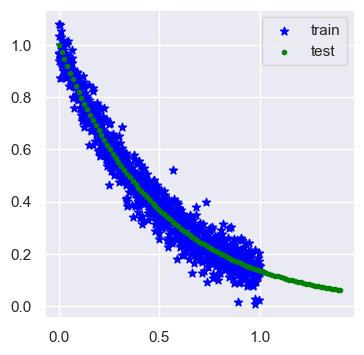

In [326]:
def sample_dataset(start, end, n, noise=0.05):
    
    x = np.linspace(start, end, n)
    sample_mean = np.exp(-2*x) 
    sample_var = noise*np.ones_like(sample_mean) 
    # sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=1)
    return x, y


start =0
end = 1.4
x_train, y_train = sample_dataset(0, 1, 1000)


figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(start, end, 100, noise = 0.0)
scatter(x_train, y_train, c="blue", marker="*", label ='train')
scatter(x_test, y_test, c="green", marker=".", label = 'test')
plt.legend()

In [327]:
batch_size = 20

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [328]:
class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.hidden_size = 15

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)
        nn.init.ones_(self.b1.weight)
        nn.init.ones_(self.b2.weight)
        nn.init.ones_(self.b3.weight)
        
    def forward(self, t):
        
        h1 = torch.tanh(self.b1(t))
        h2 = torch.tanh(self.b2(h1))
        y = self.b3(h1)
        

        return y

    def compute_dy_dx(self, x):
        self.dy_dx = torch.autograd.functional.jacobian(self, x, create_graph=True)
        self.dy_dx = torch.squeeze(self.dy_dx)
        return self.dy_dx
    
    # def compute_u_xx(self, x):
    #     self.u_xx = torch.autograd.functional.jacobian(self.compute_u_x, x)
    #     self.u_xx = torch.squeeze(self.u_xx)
    #     return self.u_xx
        
net = FeedForward()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

FeedForward(
  (b1): Linear(in_features=1, out_features=15, bias=True)
  (b2): Linear(in_features=15, out_features=15, bias=True)
  (b3): Linear(in_features=15, out_features=1, bias=True)
)
Params: 286


In [329]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

def make_plot(model):
    # Get predictions
    mu = model(tensor_x_test)

    # Create DF from predictions

    data = {
              "x": list(tensor_x_test.squeeze().detach().numpy()),
              "y": list(mu.squeeze().detach().numpy())
        }
    temp = pd.DataFrame.from_dict(data)

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=temp, x="x", y="y", c='r')

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()

In [333]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, model, inputs, targets):
        y    = model(inputs).squeeze()
        y0   = model(0*inputs) -1
        dydt = torch.diagonal(model.compute_dy_dx(inputs))
        loss = dydt + 2*y
        # print('y=', y.shape, 'dy=' , dydt.shape, 'loss=', loss.shape)
        loss = torch.mean(torch.abs(loss)) + torch.mean(torch.abs(y0))
        return loss

In [334]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.MSELoss()
pinnloss = CustomLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Epoch 0 | batch train loss: 1.579228162765503 | test loss: 1.579013204574585


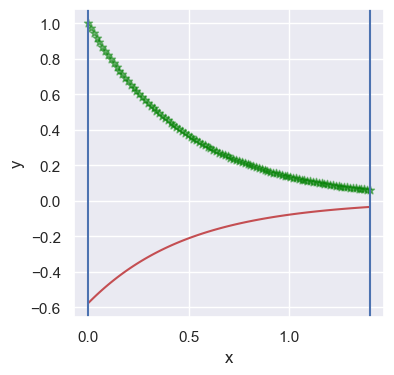

Epoch 100 | batch train loss: 0.5229250192642212 | test loss: 0.6207168817520141


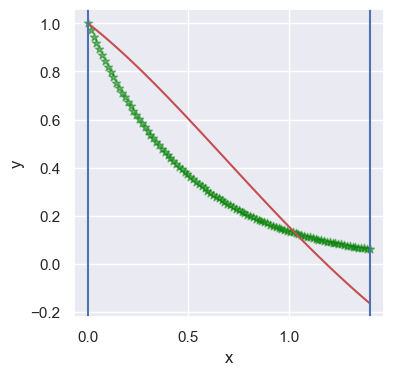

Epoch 200 | batch train loss: 0.32814711332321167 | test loss: 0.4153732419013977


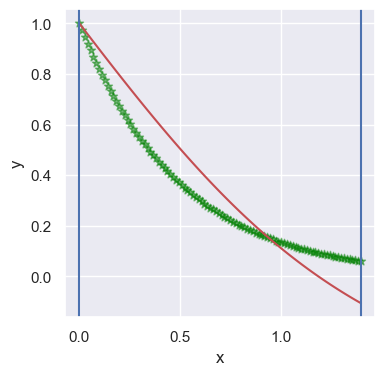

Epoch 300 | batch train loss: 0.09396778047084808 | test loss: 0.07444198429584503


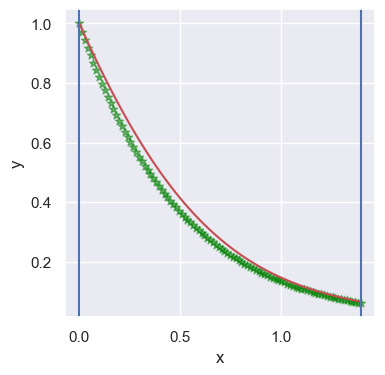

KeyboardInterrupt: 

In [335]:
for epoch in range(5000):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        
        # mu = net(x)
        # loss = criterion(mu, y)
        loss   = pinnloss(net, x, y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu = net(x)
             all_test_losses.append(pinnloss(net,x, y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot(net)

In [ ]:
x, y  = next(iter(train_loader))

In [315]:
pinnloss(net,x,y)

tensor(0.0022, grad_fn=<MeanBackward0>)

In [316]:
net(x) + torch.exp(x)

tensor([[1.2756],
        [1.5290],
        [1.3825],
        [1.3414]], grad_fn=<AddBackward0>)